## Data Prep

**Import necessary modules and the ASOS/SNOTEL dataframes**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dtb
import os
from glob import glob
import datetime as dt
import seaborn as sns
pd.show_versions()
import sys
import graphviz
sys.executable
#import graphviz


INSTALLED VERSIONS
------------------
commit: None
python: 3.6.5.final.0
python-bits: 32
OS: Windows
OS-release: 10
machine: AMD64
processor: Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8
LOCALE: None.None

pandas: 0.24.0
pytest: None
pip: 18.1
setuptools: 39.0.1
Cython: None
numpy: 1.14.3
scipy: 1.1.0
pyarrow: None
xarray: None
IPython: 6.4.0
sphinx: None
patsy: 0.5.1
dateutil: 2.7.3
pytz: 2018.4
blosc: None
bottleneck: None
tables: None
numexpr: None
feather: None
matplotlib: 2.2.2
openpyxl: None
xlrd: None
xlwt: None
xlsxwriter: None
lxml.etree: 4.2.5
bs4: None
html5lib: 1.0.1
sqlalchemy: None
pymysql: None
psycopg2: None
jinja2: 2.10
s3fs: None
fastparquet: None
pandas_gbq: None
pandas_datareader: None
gcsfs: None


'c:\\users\\rapp\\appdata\\local\\programs\\python\\python36-32\\python.exe'

In [2]:
data = [pd.read_csv('asos_snotel_UA_12hr_df.dat', parse_dates = True, index_col = 'Date_Time')]
asos_snotel_UA_df = pd.concat(data)
#asos_snotel_UA_df['LXV_WindSpeed_m/s']

#asos_snotel_UA_df.rename(columns={'LXV_WindSpeed_m/s': 'LXV_WindSpeed_mps'}, inplace=True)

asos_snotel_UA_df.astype('float16')
pd.set_option('display.expand_frame_repr', True)


print(asos_snotel_UA_df.keys())




#delete empty columns as they mess up loops
#del asos_snotel_UA_df['CMtn_6hr_Precipitation_mm']            #empty column


Index(['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
       'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps',
       'CMtn_CloudCover_oktas', 'CMtn_1hr_Precipitation_mm',
       'LXV_Temperature_degC', 'LXV_Dewpoint_degC',
       ...
       'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc',
       'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts',
       'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc',
       'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts'],
      dtype='object', length=163)


It is important to keep in mind that 'CMtnSNTL_12hr_SNWD_in contains snow depth info taken at the start of the respective 12hr period timestamp.  The snowfall calculated also gives the snowfall that fell in the 12hrs after the timestamp.  The model will utilize hourly meteorological measurements at exactly 00:00 and 12:00 hours to predict the amount of snow which will fall in the next 12 hour period.  For example, the 00:00 meteorological measurements will be used to predict the snow which fell between 00:00 and 12:00.

# Decision Tree with Surface and Upper Air Features

### Now identify variables which have good data capture

In [3]:
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_drct', 'KGJT_850mb_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_drct', 'KGJT_d850_700_speed_kts', \
 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_drct', 'KGJT_d850_500_speed_kts', \
 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_drct', 'KGJT_d850_400_speed_kts', \
 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_drct', 'KGJT_d850_300_speed_kts', \
 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_drct', 'KGJT_d850_250_speed_kts', \
 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_drct', 'KGJT_d850_200_speed_kts',\
 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', \
 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', \
 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', \
 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', 'KGJT_d700_200_speed_kts', \
 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', \
 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', \
 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', \
 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', \
 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', \
 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', \
 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', \
 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', \
 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts', \
 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts']

good_vars_sfcua = []
bad_vars_sfcua = []
for var in variables:
    idx = np.isfinite(asos_snotel_UA_df['2009':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df['2009':'2017'][var])
    total_poss = len(asos_snotel_UA_df['2009':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df['2009':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    total_avail =len(asos_snotel_UA_df['2009':'2017'][idx])
    if total_avail/total_poss >= 0.67: 
        good_vars_sfcua.append(var)
    else:
        bad_vars_sfcua.append(var)
        
print('Variables with >= 67% data match to snowfall: ')
print(good_vars_sfcua )
print('Variables with < 67% data match to snowfall: ')
print(bad_vars_sfcua )

Variables with >= 67% data match to snowfall: 
['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_

### Set up test data

In [4]:
Xtest = []
Xtest_feat =[]
Ytest = []
Ytest_actsnf = []
idx_test = []

idx_test = np.isfinite(asos_snotel_UA_df['2006':'2008']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'])
for v in good_vars_sfcua:
    idx_test = idx_test & np.isfinite(asos_snotel_UA_df['2006':'2008'][v])    
    
Ytest = round(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']['2006':'2008'][idx_test],0)
Ytest_actsnf  = Ytest.tolist()

gv = pd.DataFrame()
#gv_asos_snotel_UA_df = asos_snotel_UA_df.copy
#gv_asos_snotel_UA_df = asos_snotel_UA_df['2009':'2017'][['LXV_Temperature_degC', 'LXV_WindSpeed_mps', 'LXV_Dewpoint_degC']][loop_idx]
Xtest = asos_snotel_UA_df['2006':'2008'][good_vars_sfcua][idx_test].apply(lambda x: x.tolist(), axis=1)
#testtrain2 = testlist.apply(lambda x: testtrain2.append(x))
Xtest_feat = Xtest.tolist()
print(Xtest_feat[0:5], Ytest_actsnf[0:5])


[[-3.2, -7.0, -8.0, 340.0, 5.1, -4.4, -7.2, 993.4, 2.6, 70.0, -5.2, 11750.0, -45.1, -51.1, 265.0, 35.0, 10260.0, -44.1, -49.1, 265.0, 24.0, 9050.0, -45.1, -49.5, 250.0, 25.0, 7100.0, -33.9, -37.1, 245.0, 4.0, 5490.0, -21.3, -23.4, 270.0, 24.0, 2921.0, -4.7, -5.4, 260.0, 36.0, 1364.0, -1557.0, -4126.0, -5736.0, -7686.0, -8896.0, -10386.0, -2569.0, 16.6, 18.0, -10.0, 12.0, -4179.0, 29.2, 31.7, 15.0, 32.0, -6129.0, 40.4, 44.1, 10.0, 11.0, -7339.0, 39.4, 43.7, -5.0, 12.0, -8829.0, 40.4, 45.7, -5.0, 1.0, -1610.0, 12.6, 13.7, 25.0, 20.0, -3560.0, 23.8, 26.1, 20.0, -1.0, -4770.0, 22.8, 25.7, 5.0, 0.0, -6260.0, 23.8, 27.7, 5.0, -11.0, -1950.0, 11.2, 12.4, -5.0, -21.0, -3160.0, 10.2, 12.0, -20.0, -20.0, -4650.0, 11.2, 14.0, -20.0, -31.0, -1210.0, -1.0, -0.4, -15.0, 1.0, -2700.0, 0.0, 1.6, -15.0, -10.0, -1490.0, 1.0, 2.0, 0.0, -11.0], [-8.2, -9.0, -12.0, 290.0, 7.7, -7.0, -9.0, 1004.3, 1.5, 180.0, -5.4, 11730.0, -53.5, -73.5, 285.0, 60.0, 10280.0, -49.5, -69.5, 290.0, 62.0, 9080.0, -44.7, -63.7,

### Set up training data with 2009-200

In [5]:
Xtrain = []
Xtrain_feat =[]
Ytrain = []
Ytrain_actsnf = []
idx_test = []

idx_train = np.isfinite(asos_snotel_UA_df['2009':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'])
for v in good_vars_sfcua:
    idx_train = idx_train & np.isfinite(asos_snotel_UA_df['2009':'2017'][v])    
    
Ytrain = round(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']['2009':'2017'][idx_train],0)
Ytrain_actsnf = Ytrain.tolist()


gv = pd.DataFrame()
#gv_asos_snotel_UA_df = asos_snotel_UA_df.copy
#gv_asos_snotel_UA_df = asos_snotel_UA_df['2009':'2017'][['LXV_Temperature_degC', 'LXV_WindSpeed_mps', 'LXV_Dewpoint_degC']][loop_idx]
Xtrain = asos_snotel_UA_df['2009':'2017'][good_vars_sfcua][idx_train].apply(lambda x: x.tolist(), axis=1)
#testtrain2 = testlist.apply(lambda x: testtrain2.append(x))
Xtrain_feat = Xtrain.tolist()
    
print(Xtrain_feat[0:5], Ytrain_actsnf[0:5])

    

[[-6.6, -11.0, -14.0, 270.0, 15.4, -8.3, -10.0, 1011.7, 7.2, 30.0, -0.1, 11890.0, -63.7, -71.7, 335.0, 100.0, 10490.0, -53.5, -62.5, 335.0, 100.0, 9290.0, -43.1, -51.1, 330.0, 96.0, 7280.0, -25.3, -36.3, 325.0, 74.0, 5630.0, -15.3, -20.3, 320.0, 58.0, 3032.0, -6.1, -7.7, 285.0, 29.0, 1506.0, -1526.0, -4124.0, -5774.0, -7784.0, -8984.0, -10384.0, -2598.0, 9.2, 12.6, -35.0, -29.0, -4248.0, 19.2, 28.6, -40.0, -45.0, -6258.0, 37.0, 43.4, -45.0, -67.0, -7458.0, 47.4, 54.8, -50.0, -71.0, -8858.0, 57.6, 64.0, -50.0, -71.0, -1650.0, 10.0, 16.0, -5.0, -16.0, -3660.0, 27.8, 30.8, -10.0, -38.0, -4860.0, 38.2, 42.2, -15.0, -42.0, -6260.0, 48.4, 51.4, -15.0, -42.0, -2010.0, 17.8, 14.8, -5.0, -22.0, -3210.0, 28.2, 26.2, -10.0, -26.0, -4610.0, 38.4, 35.4, -10.0, -26.0, -1200.0, 10.4, 11.4, -5.0, -4.0, -2600.0, 20.6, 20.6, -5.0, -4.0, -1400.0, 10.2, 9.2, 0.0, 0.0], [-7.3, -11.0, -15.0, 270.0, 11.04, -8.0, -11.0, 1025.1, 5.7, 350.0, -4.0, 11840.0, -57.5, -68.5, 330.0, 105.0, 10440.0, -56.1, -67.1, 350.

### Run model with suface features only

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
3.2040136835020503


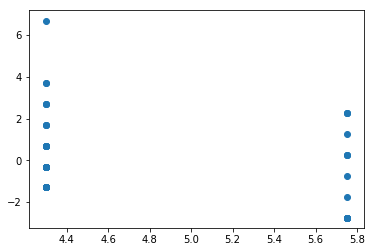

In [6]:
clf =[]
Y_predsnf = []

from sklearn import tree
clf = tree.DecisionTreeRegressor(max_depth=3)
clf = clf.fit(Xtrain_feat, Ytrain_actsnf)

print(clf)

# Predict test set labels
Y_predsnf = clf.predict(Xtest_feat)
# Evaluate test-set accuracy


from sklearn.metrics import mean_squared_error
print(mean_squared_error(Ytest_actsnf, Y_predsnf))
#print(accuracy_score(Ytest_actsnf, Y_predsnf))
#plt.plot(Ytestlist-y_pred) 


plt.scatter(Y_predsnf, Ytest_actsnf-Y_predsnf)

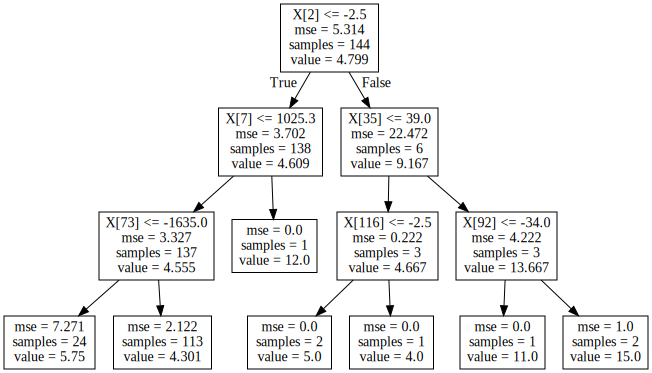

In [7]:

import graphviz 

dot_data = tree.export_graphviz(clf, out_file=None, feature_names=good_vars_sfcua, filled = True,special_characters = True, class_names = True, max_depth = 3) 
graph = graphviz.Source(dot_data) 
#graph.render() 
#dot_data = tree.export_graphviz(clf, out_file=None, 
#                      feature_names=iris.feature_names,  
#                      class_names=iris.target_names,  
#                      filled=True, rounded=True,  
#                      special_characters=True)

dot_data = tree.export_graphviz(clf)

graph = graphviz.Source(dot_data)  
graph 

Try max depth 10

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
5.977380218796116


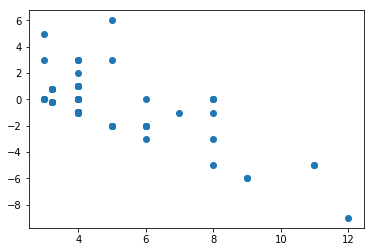

In [9]:
clf =[]
Y_predsnf = []

from sklearn import tree
clf = tree.DecisionTreeRegressor(max_depth=10)
clf = clf.fit(Xtrain_feat, Ytrain_actsnf)

print(clf)

# Predict test set labels
Y_predsnf = clf.predict(Xtest_feat)
# Evaluate test-set accuracy

from sklearn.metrics import mean_squared_error
print(mean_squared_error(Ytest_actsnf, Y_predsnf))
#plt.plot(Ytestlist-y_pred) 


plt.scatter(Y_predsnf, Ytest_actsnf-Y_predsnf)

Try multpile max depths

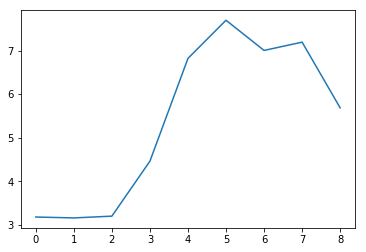

In [11]:
from sklearn import tree
from sklearn.metrics import accuracy_score
accuracy = []

for i in range(1,10):
  clf = []
  clf = tree.DecisionTreeRegressor(max_depth=i)
  clf = clf.fit(Xtrain_feat, Ytrain_actsnf)

#print(clf)

# Predict test set labels
  Y_predsnf = clf.predict(Xtest_feat)
# Evaluate test-set accuracy


  accuracy.append(mean_squared_error(Ytest_actsnf, Y_predsnf))
#plt.plot(Ytestlist-y_pred) 

plt.plot(accuracy)
#plt.scatter(y_pred, Ytestlist-y_pred)